Power Law Distributions
=======================

(Note: Be sure to either download the data that goes with this notebook or uncomment/edit the lines below needed to get your own data before executing the code in this notebook.)

It turns out that "power law" distributions are ubitquitous in nature[1]. 

1 <http://arxiv.org/abs/cond-mat/0412004>

In the cells that follow I measure the number of files of different sizes on my hard disk. Then I proceed to quantify (in the simples possible way) the distribution of file sizes in a certain range as a power law distribution.


In [1]:
%pylab inline

import pandas as pd                    # pandas is the "python data analysis package"
import os                              # operating system services
from scipy.optimize import curve_fit   # non-linear curve fitting

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getFileSizes(folder, minsize=2000, maxsize=10**9):
    """
    return a list of file sizes in a folder
    """
    sizes = []
    for (path, dirs, files) in os.walk(folder):
        for file in files:
            try:
                filename = os.path.join(path, file)
                size=os.path.getsize(filename)
                if size>minsize and size<maxsize:
                    sizes.append(size)
            except OSError:
                pass
    return sizes

In [3]:
if 1:
    minsize=10**5
    maxsize=10**9
    sizes = getFileSizes('/Users/steve/Desktop',minsize,maxsize) # <--- edit this to match some folder with a lot of files
    print(len(sizes), 'files between', minsize, 'and', maxsize)

2523 files between 100000 and 1000000000


In [4]:
if 1:
    df=open('myData.csv','w')
    for item in sizes:
        df.write(str(item) + '\n')
    print(len(sizes),"rows written")
    df.close()
else:
    sizes=[]
    df=open('myData.csv','r')
    reader=csv.reader(df)
    for row in reader:
        sizes.append(int(row[0]))
    df.close()
    print(len(sizes),"rows read")


2523 rows written


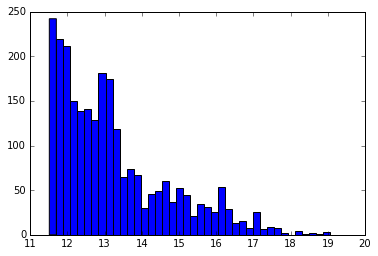

In [5]:
ns,bins,patches = hist(log(array(sizes)+1),40)

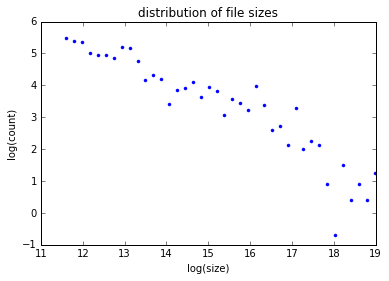

In [6]:
xvals=(bins[:-1]+bins[1:])/2.0
counts=ns+0.5
yvals=log(counts)
title("distribution of file sizes")
ylabel("log(count)")
xlabel("log(size)")
plot(xvals,yvals,'b.')

Fitting Data with Matrices 
===========================

We can see that we have something that looks like it might be a power law. How can we tell? We'll use "linear least squares" analysis.

When fitting some experimental data to a model, there are typically
a set of paramters $(\alpha_1, \alpha_2, \ldots, \alpha_n)$ that
need to be found so that the function $\chi^2$ is a minimum. 
We can think of the paramters as an n-vector called $\alpha$. The
data consist of a set of paired numbers $(x_i, y_i)$ and we can
define $\chi^2$ as 

\begin{equation}
\chi^2 = \sum_{i=1}^{m} {(y_i - y^\star(x_i,\alpha))^2\over \sigma_i^2},
\end{equation}

where $\sigma_i$ is the uncertainty in $y_i$, and $y^\star$ is the
model value corresponding to $x_i$ (and the value of the parameters
$\alpha$). If the model $y^\star(x,\vec\alpha)$ is *linear* then we
can write $y^\star$ as:

\begin{equation}
y^\star (x) = \alpha_1 X_1(x)+\alpha_2 X_2(x)+\ldots+\alpha_n X_n(x).
\end{equation}

or

\begin{equation}
y^\star(x) = \sum_{j=1}^{n} \alpha_j X_j(x),
\end{equation}

where the $X_j$ are a set of functions that are to be superposed
with coefficients $\alpha_j$ to form the model. A common example
of this would be a straight line fit $y^\star(x) = mx+b$ where the
functions are $x$ and 1 for the paramters $m$ and $b$ respectively.

Notice that, since the $x$'s are at fixed measured values, this whole thing can be 
cast into a single matrix equation. If we define the following $M$ matrix:

\begin{equation}
M_{ij} = X_j(x_i)
\end{equation}

and if we think of $y^\star$ as an $m$-vector of model 
values evaluated at the $m$ data points $x_i$ and $y$ as an 
experimental $m$-vector $y$, then the model vector
can be evaluated by matrix multiplication as:

\begin{equation}
y^\star = M \alpha
\end{equation}

and the difference vector between the model and the data becomes simply

\begin{equation}
y - y^\star = y - M\alpha
\end{equation}

Finally we can write $\chi^2$ as 

\begin{equation}
\chi^2 = (y - M\alpha)^T S (y - M\alpha) \,\,\,\,\,\,\,\,(1)
\end{equation}

where $S$ is a diagonal matrix of $1/\sigma_i^2$ and
the $T$ on the left side means "transpose".

Now it is a simple matter to find the values of the paramters that
minimize $\chi^2$. We require that $\nabla_{\alpha}\chi^2 = 0$. 
If you play around with this you can convince yourself that this means:

\begin{equation}
M^T S(y - M\alpha) = 0
\end{equation}

and therefore:

\begin{equation}
\alpha = (M^T SM)^{-1}M^T S y.  \,\,\,\,\,\,\,\,(2)
\end{equation}

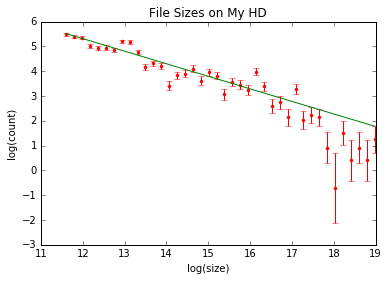

In [7]:
#
# define the function values (these are the columns of the "M" matrix
#
# generate arrays that contain "functions" of x that are combined to form the model
#

def doFit(funcs, xvals, yvals, sigma):
    """
    doFit uses matrices to solve for the linear least squares 
    fit parameters based on the list of 'funcs', and the x-y values
    and their corresponding uncertainties (sigma).
    
    returns the array of model parameters
    """
    #
    # define the S matrix in terms of uncertainties
    #
    
    S=diag((1.0/sigma)**2)
    
    #
    # define the model matrix
    #
    
    M = array(funcs).T
    MtM = M.T.dot(S.dot(M))
    MtMInv = inv(MtM)
    MtY = M.T.dot(S.dot(yvals))
    alpha = MtMInv.dot(MtY)      # see eq 2 above.
    
    #
    # solve for the parameters, and return
    #
    ystar = M.dot(alpha)
    
    return (alpha, ystar, MtMInv)

fx1 = ones(len(xvals))   # X_1(x) = 1
fx2 = xvals              # X_2(x) = x

sigma=1.0/sqrt(abs(counts))

alpha, ystar, fcov = doFit([fx1, fx2], xvals, yvals, sigma)

mFit = alpha[1]
bFit = alpha[0]

errorbar(xvals, yvals, sigma, fmt='r.') 
title("File Sizes on My HD")
ylabel("log(count)")
xlabel("log(size)")
plot(xvals,ystar, 'g-')


Uncertainties in the Parameters
-------------------------------

There are a variety of techniques for estimating the uncertainty in the parameters you compute. The approach we'll take is one of the more "brute force" approaches, but it's pretty robust. We're going to fabricate data that has the same statistics as our original data (do the degree that we know and/or care). Then we'll fit the fabricated data many times (1000 times in this case) and we'll look at the statistics of the fit parameters produced. From this we can tell how well our fit has done at narrowing down the parameters we computed.


In [9]:
#
# Now do monte-carlo data fabrication and fit analysis
#

N=1000    # number of samples to take
mList=[]  # keep track of monte-carlo fit parameters
bList=[]

for i in range(N):
    """
    Generate mc data with the same statistical properties as the real data.
    Repeat the fit for each set, and record the parameters.
    """
    mcY = ystar + sigma*normal(size=len(xvals))
    mcAlpha,mcYstar,mccov = doFit([fx1,fx2],xvals,mcY,sigma)   # repeatedly fit mc data
    mList.append(mcAlpha[1])
    bList.append(mcAlpha[0])
    
#
# Compute the statistics of the mc-results
#

marr=array(mList)
barr=array(bList)

mAvg = marr.sum()/N
bAvg = barr.sum()/N
delM = marr-mAvg
delB = barr-bAvg
sigM = sqrt((delM*delM).sum()/(N-1))  # sigM is the std-deviation of the m values
sigB = sqrt((delB*delB).sum()/(N-1))  # sigB is the std-deviation of the b values

#
# plot the fit
#
print("Slope=", mFit, '+/-', sigM, "(", mFit - sigM,",",mFit + sigM, ")")
print("Intercept=", bFit, '+/-', sigB, "(", bFit - sigB,",",bFit + sigB, ")")

#
# Just for fun print out the diagonals of the covariance matrix.
#
print # print a blank link
print("Compare to cov-matrix for fun:")
print("sqsrt(cov[1,1]) (should be sigma m)", sqrt(fcov[1,1]))
print("sqrt(cov[0,0]) (should be sigma b)", sqrt(fcov[0,0]))


Slope= -0.506394931483 +/- 0.0132834275819 ( -0.519678359065 , -0.493111503901 )
Intercept= 11.3892783866 +/- 0.176327765241 ( 11.2129506214 , 11.5656061519 )
Compare to cov-matrix for fun:
sqsrt(cov[1,1]) (should be sigma m) 0.0132218124342
sqrt(cov[0,0]) (should be sigma b) 0.176207038276


m average: -0.506334294806
m sigma: 0.0132834275819


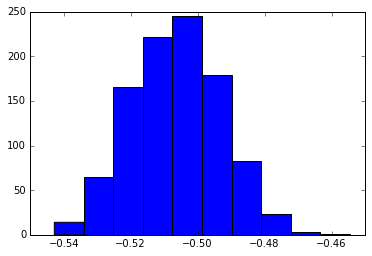

In [10]:
hist(marr) # look at the variation in "m" values
print("m average:", mAvg)
print("m sigma:",sigM)

b average: 11.3887016873
b sigma: 0.176327765241


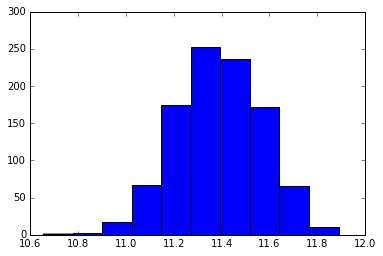

In [11]:
hist(barr)  # look at the variation in "b" values
print("b average:", bAvg)
print("b sigma:",sigB)

Slope= -0.506394931483 +/- 0.0135601719566 ( -0.51995510344 , -0.492834759527 )
Intercept= 11.3892783866 +/- 0.180276663432 ( 10.9863913766 , 11.5695550501 )

Compare to cov-matrix for fun:
sqsrt(pcov[0,0]) (should be sigma m) 0.030230895174
sqrt(pcov[1,1]) (should be sigma b) 0.402887010007


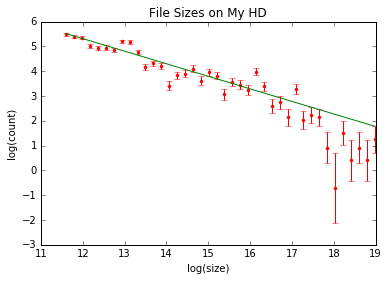

In [13]:
#
# Just to see same data fit using the non-linear scipy package "curve_fit":
#

def fLinear(x, m, b):
    return m*x + b

popt, pcov = curve_fit(fLinear, xvals, yvals, p0=(alpha[1],alpha[0]), sigma=sigma)

m=popt[0]          # slope
dm=sqrt(pcov[0,0]) # sqrt(variance(slope))
b=popt[1]          # int
db=sqrt(pcov[1,1]) # sqrt(variance(int))
ystar=fLinear(xvals, m, b)

N=1000    # number of samples to take
mList=[]  # keep track of monte-carlo fit parameters
bList=[]

for i in range(N):
    """
    Generate mc data with the same statistical properties as the real data.
    Repeat the fit for each set, and record the parameters.
    """
    mcY = ystar + sigma*normal(size=len(xvals))  # generate fabricated data to fit
    mcpopt, mcpcov = curve_fit(fLinear, xvals, mcY, p0=(m,b), sigma=sigma)
    mList.append(mcpopt[0])  # store the fit paramters for the fab-data
    bList.append(mcpopt[1])
    
#
# Compute the statistics of the mc-results
#
marr=array(mList)
barr=array(bList)

mAvg = marr.sum()/N
bAvg = barr.sum()/N
delM = marr-mAvg
delB = barr-bAvg
sigM = sqrt((delM*delM).sum()/(N-1))  # sigM is the std-deviation of the m values
sigB = sqrt((delB*delB).sum()/(N-1))  # sigB is the std-deviation of the b values

errorbar(xvals, yvals, sigma, fmt='r.') 
title("File Sizes on My HD")
ylabel("log(count)")
xlabel("log(size)")
plot(xvals,ystar, 'g-')
print("Slope=", m, '+/-', sigM, "(", m-sigM,",",m+sigM, ")")
print("Intercept=", b, '+/-', sigB, "(", b-db,",",b+sigB, ")")

print() # print a blank link
print("Compare to cov-matrix for fun:")
print("sqsrt(pcov[0,0]) (should be sigma m)", sqrt(pcov[0,0]))
print("sqrt(pcov[1,1]) (should be sigma b)", sqrt(pcov[1,1]))


Project 7
=========

See this reference for other systems that exhibit power law behavior:

<http://arxiv.org/abs/cond-mat/0412004>

Or test your intuition and see if it's right. Many system exhibit this behavior!

Get some data, and test your idea. Use the matrix technique to do the fitting.